In [9]:
import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.graphs as eg

import torch
from torch import exp, kron, eye, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp


from IPython.display import display, Markdown

In [3]:
h = 1
r = 10
n = [int(np.ceil((4/np.sqrt(3))*r)), 2*r]

fibre, xr, nc, dist = eg.honeycombgrid(h, n, active = lambda x,y: (x**2 + y**2 <= (r*h)**2) )

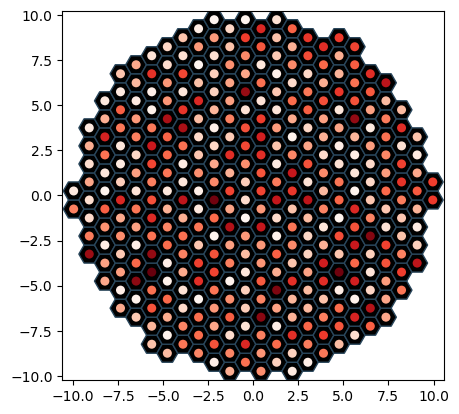

In [4]:
fig, ax = plt.subplots()
u = torch.rand(nc, dtype=torch.complex128)
activations = eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(u)**2)
plt.show()

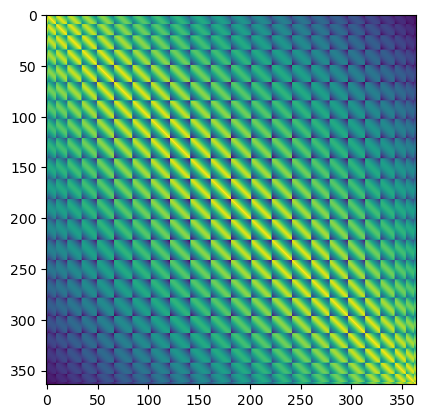

In [30]:
c = 2.
plt.imshow(torch.log(exp(-c*dist/h)))
plt.show()

In [6]:
H = exp(-c*dist/h) + 0.1*torch.diag(torch.randn(nc))

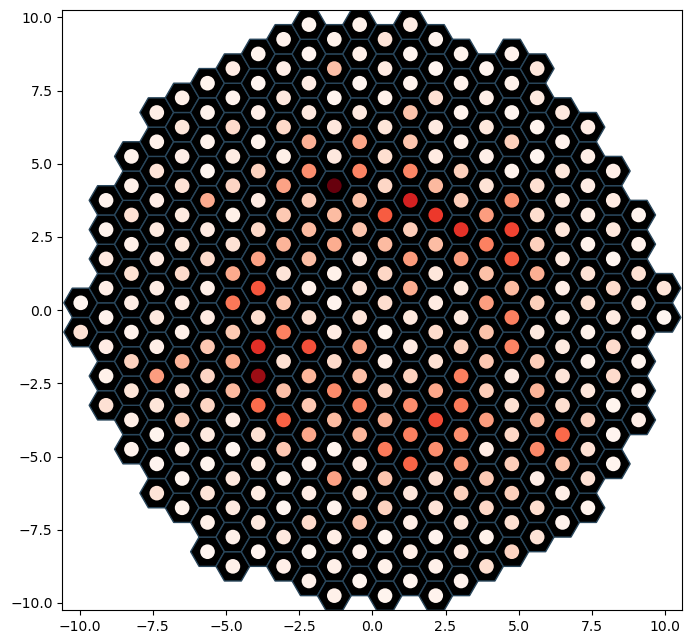

In [61]:
L = 10
uT = torch.matrix_exp(-1j*L*H) @ u
fig, ax = plt.subplots(figsize=(8,8))
activations = eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uT)**2)
plt.show()

In [8]:
exactstep = lambda t, h, u0: torch.matrix_exp(-1j*h*H) @ u0 

L = 50
trange = [0, L]
timegrid = es.timegrid(trange, ndt=1000)
uT, obsvalues, uintermediate = es.solvediffeq(u, timegrid, exactstep, observables = {}, storeintermediate = True)

In [10]:
drawframe = lambda ax, frame: eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uintermediate[frame])**2)
outputgif = 'multicorefibre.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))

![gif](multicorefibre.gif)

In [12]:
K = 1
nonlinearstep = lambda t, h, u0: torch.matrix_exp(-1j*h*(H + K*torch.diag(abs(u0)**2))) @ u0 

L = 10
trange = [0, L]
timegrid = es.timegrid(trange, ndt=100)
uT, obsvalues, uintermediateNLS = es.solvediffeq(u, timegrid, nonlinearstep, observables = {}, storeintermediate = True)

In [13]:
drawframe = lambda ax, frame: eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uintermediateNLS[frame])**2)
outputgif = 'multicorefibreNLS.gif'
es.animate(drawframe, len(uintermediateNLS), outputgif, speedfactor=1, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))

![gif](multicorefibreNLS.gif)

## Image loading

In [11]:
from torchvision import datasets, transforms

# Define the data transformation (normalize and convert to PyTorch tensors)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST training set
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Download and load the MNIST test set
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 9474099.35it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14472603.80it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8540984.52it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4536920.40it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



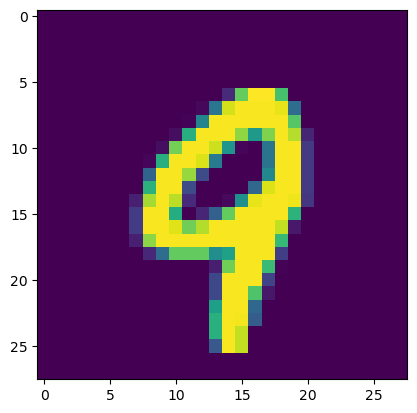

In [87]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
image = images[7][0]
plt.imshow(image)

In [131]:
from scipy.interpolate import griddata

# need to create these once
x,y = torch.meshgrid(torch.linspace(-10,10,28),torch.linspace(10,-10,28), indexing='xy')
flat_points = torch.stack([x.flatten(), y.flatten()]).T

def fibreinput(image):
    flat_image = image.flatten()
    # Perform 2D interpolation using griddata
    interpolated_values = griddata(flat_points, flat_image, fibre, method='linear')
    uin = torch.tensor(interpolated_values)
    uin = uin - torch.min(uin)
    uin = uin/torch.max(uin)
    return es.utils.complexify(torch.sqrt(uin))

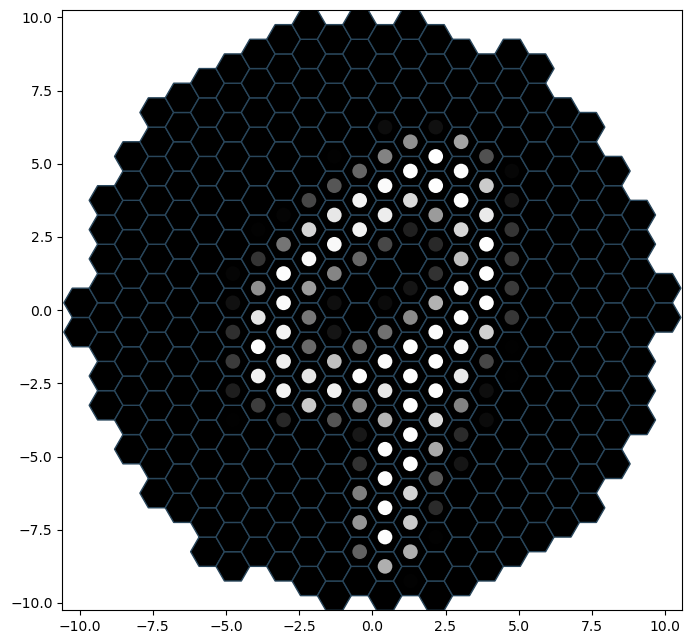

In [132]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8,8))
uin = fibreinput(images[7][0])
activations = eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uin)**2, activationscolormap=mpl.colormaps['gray'])
plt.show()

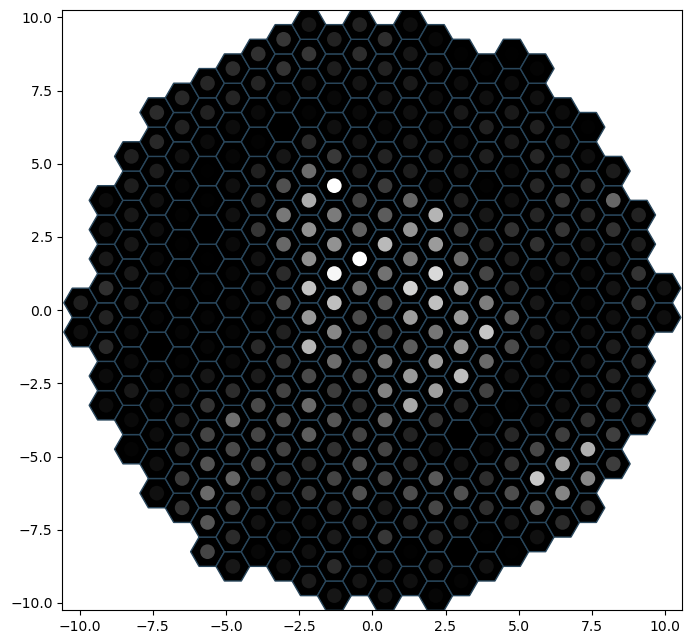

In [135]:
L = 10
uout =  torch.matrix_exp(-1j*L*H) @ uin
fig, ax = plt.subplots(figsize=(8,8))
activations = eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uout)**2, activationscolormap=mpl.colormaps['gray'])
plt.show()


In [136]:
exactstep = lambda t, h, u0: torch.matrix_exp(-1j*h*H) @ u0 

L = 10
trange = [0, L]
timegrid = es.timegrid(trange, ndt=1000)
uT, obsvalues, uintermediate = es.solvediffeq(uin, timegrid, exactstep, observables = {}, storeintermediate = True)

In [138]:
drawframe = lambda ax, frame: eg.drawhoneycomb(ax, xr, h, fibre, intensities=torch.abs(uintermediate[frame])**2, activationscolormap=mpl.colormaps['gray'])
outputgif = 'multicorefibreMNIST9.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False, size=(1440, 1440))
display(Markdown(f'![gif]({outputgif})'))

![gif](multicorefibreMNIST9.gif)